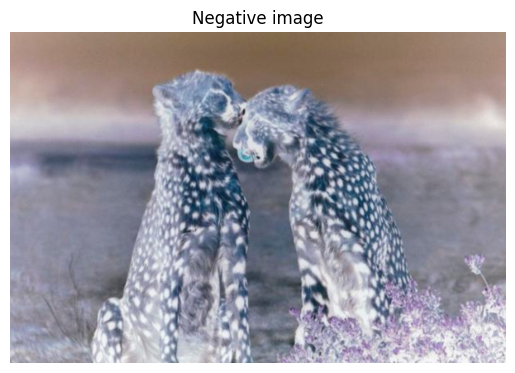

Recovery time: 0.021053 seconds


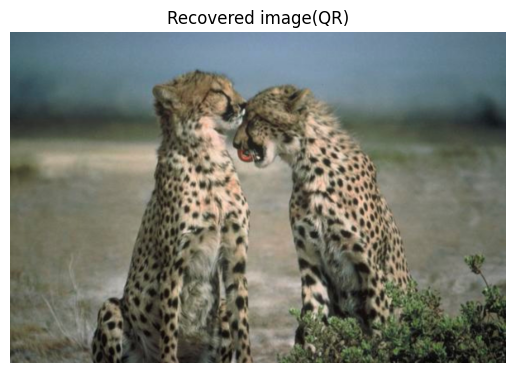

In [2]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

np.random.seed(42)

def identity_matrix(n):
    return [[1 if i == j else 0 for j in range(n)] for i in range(n)]

def zeros_matrix(rows, cols):
    return [[0 for _ in range(cols)] for _ in range(rows)]

def transpose(M):
    return [[M[j][i] for j in range(len(M))] for i in range(len(M[0]))]

def dot(u, v):
    return sum([u[i] * v[i] for i in range(len(u))])

def norm(v):
    return sum([v[i] * v[i] for i in range(len(v))]) ** 0.5

def matmul(A, B):
    result = zeros_matrix(len(A), len(B[0]))
    for i in range(len(A)):
        for j in range(len(B[0])):
            result[i][j] = sum([A[i][k] * B[k][j] for k in range(len(B))])
    return result

def scalar_multiply(scalar, v):
    return [scalar * vi for vi in v]

def vector_subtract(u, v):
    return [u[i] - v[i] for i in range(len(u))]

def gram_schmidt_qr(A):
    n = len(A)
    m = len(A[0])
    Q = []
    R = zeros_matrix(m, m)
    
    for j in range(m):
        a_j = [A[i][j] for i in range(n)]
        q_j = a_j[:]
        
        for i in range(j):
            q_i = [Q[row][i] for row in range(n)]
            R[i][j] = dot(q_i, a_j)
            proj = scalar_multiply(R[i][j], q_i)
            q_j = vector_subtract(q_j, proj)
        
        R[j][j] = norm(q_j)
        q_j = [val / R[j][j] for val in q_j]
        
        if j == 0:
            Q = [[val] for val in q_j]
        else:
            for row in range(n):
                Q[row].append(q_j[row])
                
    return Q, R

def upper_tri_inverse(R, tol=1e-6): 
    n = len(R)
    R_inv = zeros_matrix(n, n)

    for i in range(n - 1, -1, -1):
        if abs(R[i][i]) < tol: 
            R_inv[i][i] = 1 / (R[i][i] if abs(R[i][i]) >= tol else tol)
        else:
            R_inv[i][i] = 1 / R[i][i]
        
        for j in range(i + 1, n):
            total = 0
            for k in range(i + 1, j + 1):
                total += R[i][k] * R_inv[k][j]
            R_inv[i][j] = -total / R[i][i]

    return R_inv

def qr_inverse(A):
    Q, R = gram_schmidt_qr(A)
    R_inv = upper_tri_inverse(R)
    Q_T = transpose(Q)
    return matmul(R_inv, Q_T)


def restore_image(negative_img):
    img = negative_img.astype(np.float32)

    h, w, _ = img.shape
    ones = np.ones((h, w, 1), dtype=np.float32)
    img_homogeneous = np.concatenate((img, ones), axis=2)

    img_reshaped = img_homogeneous.reshape(-1, 4).T
    restored = np.matmul(T_inv, img_reshaped)

    restored = restored[:3, :].T.reshape(h, w, 3)
    restored = np.clip(restored, 0, 255).astype(np.uint8)

    return restored

def show_image(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

T = [
    [-1, 0, 0, 255],
    [0, -1, 0, 255],
    [0, 0, -1, 255],
    [0, 0, 0, 1]
]

T_inv = qr_inverse(T)
T_inv = np.array(T_inv)

input_path = 'negative.png'
negative_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

if negative_img is None:
    print("Помилка: не вдалося завантажити зображення.")
else:
    if negative_img.shape[2] == 4:
        negative_img = negative_img[:, :, :3]

    show_image(negative_img, "Negative image")

    start_time = time.time()
    restored_img = restore_image(negative_img)
    end_time = time.time()

    print(f"Recovery time: {end_time - start_time:.6f} seconds")

    show_image(restored_img, "Recovered image(QR)")

    output_path = 'restored_image.png'
    cv2.imwrite(output_path, restored_img)